In [ ]:
import sys
sys.path.insert(1, '../../../../utils')
from pandas import read_csv, DataFrame, Series, concat
from studies import *
from dslabs_functions import *
from numpy import ndarray
from matplotlib.pyplot import savefig, show, figure, subplots
from imblearn.over_sampling import SMOTE


In [101]:
# Load data (already split into train/test)
train_filename = "../../data/prepared/mvi/flight_mvi_sampled_train.csv"
test_filename = "../../data/prepared/mvi/flight_mvi_sampled_test.csv"

train_data: DataFrame = read_csv(train_filename, na_values="")
test_data: DataFrame = read_csv(test_filename, na_values="")

target = "Cancelled"
target_name = "Cancelled"
file_tag = "flight"
metric = "recall"
lab_folder_bal = "lab3_preparation/balancing"

print(train_data.shape, test_data.shape)

(70000, 182) (30000, 182)


Minority class= True : 2293
Majority class= False : 67707
Proportion: 0.03 : 1


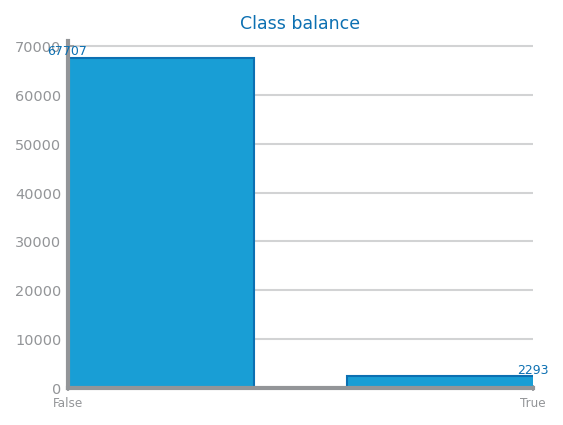

In [102]:
# Analyze class balance
target_count: Series = train_data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

In [103]:
# Separate positive and negative classes (only use train data)
df_positives: Series = train_data[train_data[target] == positive_class]
df_negatives: Series = train_data[train_data[target] == negative_class]

### Undersampling

In [104]:
approach_bal1 = "Undersampling"

# Undersample majority class to match minority class size
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives), random_state=42))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)

under_target_count: Series = df_under[target].value_counts()
print("Minority class=", positive_class, ":", under_target_count[positive_class])
print("Majority class=", negative_class, ":", under_target_count[negative_class])
print("Proportion:", round(under_target_count[positive_class] / under_target_count[negative_class], 2), ": 1")
print(df_under.shape)

Minority class= True : 2293
Majority class= False : 2293
Proportion: 1.0 : 1
(4586, 182)


In [105]:
# Remove FlightDate for evaluation
df_under = df_under.drop(columns=["FlightDate"], errors="ignore")
test_data_eval = test_data.drop(columns=["FlightDate"], errors="ignore")

Couldn't run MultinomialNB


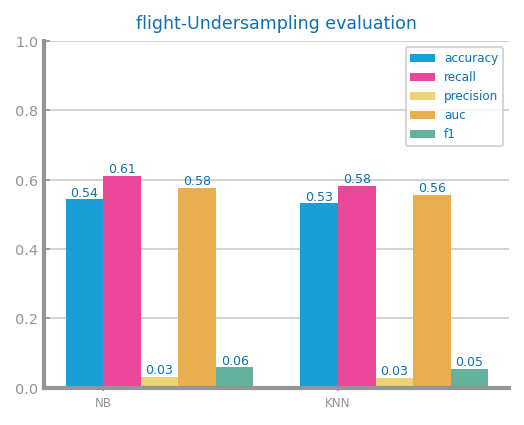

In [106]:
figure()
eval: dict[str, list] = evaluate_approach(df_under, test_data_eval, target=target_name, metric=metric)
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_bal1} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal1}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

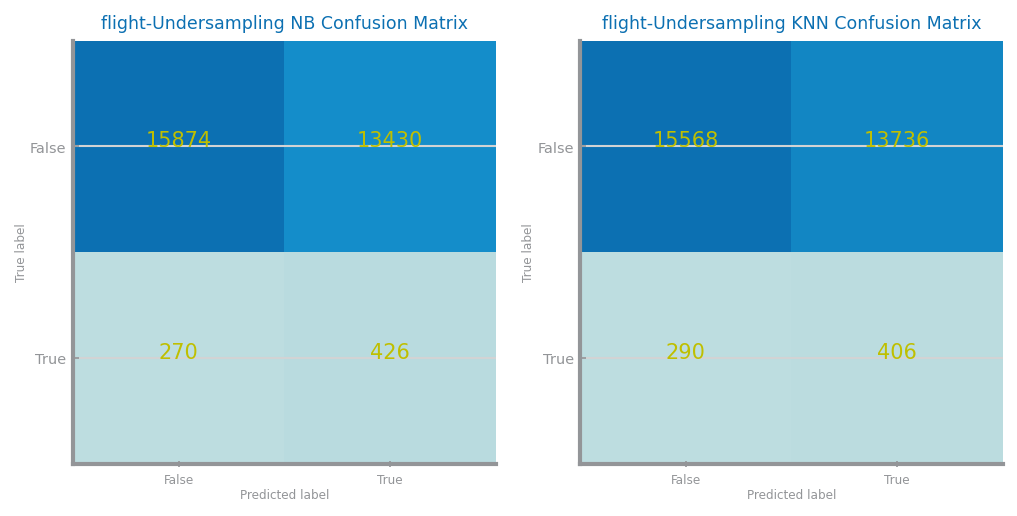

In [107]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = test_data[target_name].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_bal1} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_bal1} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal1}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()

### SMOTE

In [108]:
approach_bal2 = "SMOTE"

# Create a copy of train data for SMOTE
train_smote = train_data.copy()

# Remove FlightDate before SMOTE and store it for later
flightdate_train: Series = train_smote.pop("FlightDate")

# Separate features and target
y = train_smote.pop(target).values
X: ndarray = train_smote.values

# Apply SMOTE
smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=42)
smote_X, smote_y = smote.fit_resample(X, y)

# Reconstruct DataFrame with proper columns
df_smote: DataFrame = DataFrame(smote_X, columns=train_smote.columns)
df_smote[target] = smote_y

# Add back FlightDate - synthetic samples won't have meaningful dates
df_smote["FlightDate"] = None

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= True : 67707
Majority class= False : 67707
Proportion: 1.0 : 1
(135414, 182)


In [109]:
# Remove FlightDate from SMOTE data for evaluation
df_smote = df_smote.drop(columns=["FlightDate"], errors="ignore")
test_data_eval = test_data.drop(columns=["FlightDate"], errors="ignore")

Couldn't run MultinomialNB


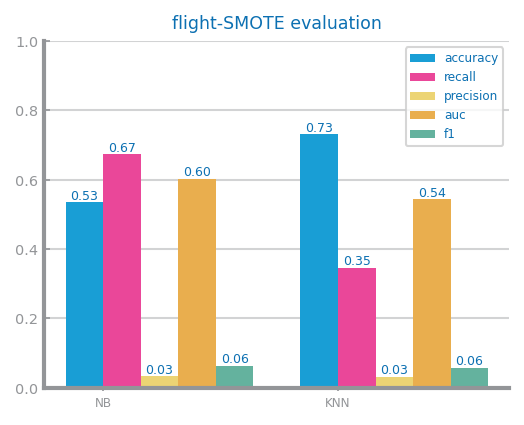

In [110]:
figure()
eval: dict[str, list] = evaluate_approach(df_smote, test_data_eval, target=target_name, metric=metric)
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_bal2} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal2}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

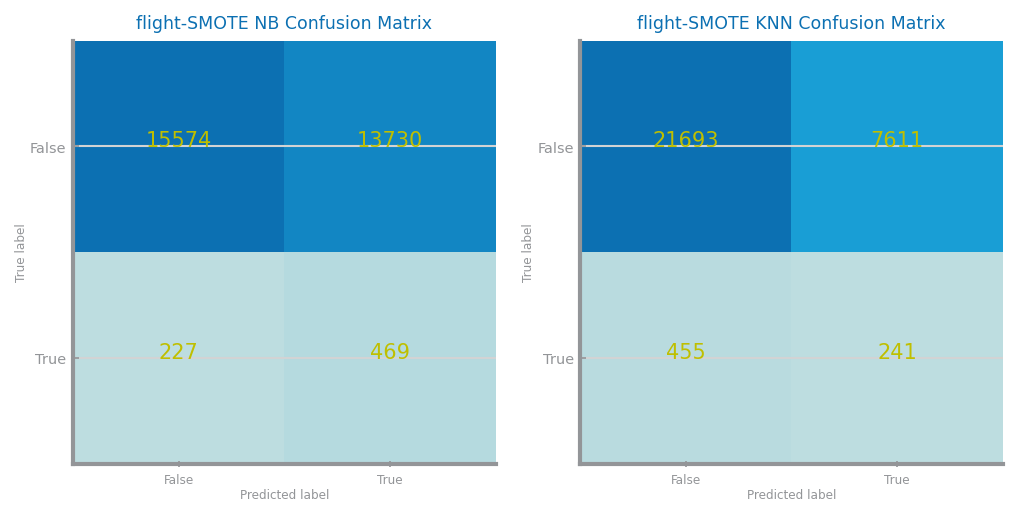

In [111]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = test_data[target_name].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_bal2} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_bal2} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal2}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()